## Env Creative

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm
import matplotlib.pyplot as plt
import imageio.v2

## Function to add Gaussian noise to the image

In [2]:
def add_noise(img, noise_level):
    noise = np.random.normal(0, noise_level, img.shape)
    noisy_img = img + noise
    return np.clip(noisy_img, 0, 1)

## Define the DIP model (Assuming a simple CNN architecture)

In [3]:
class DIPModel(nn.Module):
    def __init__(self):
        super(DIPModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 3, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)
        return x

## Define Show Image Function

## Load target image

In [4]:
img_path = '/kaggle/input/lenna-test-image/Lenna_(test_image).png'
target_img = plt.imread(img_path)

In [5]:
if target_img.dtype == np.uint8:
    target_img = target_img / 255.0

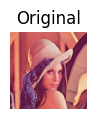

In [6]:
plt.figure(figsize=(3, 1))
plt.title("Original")
plt.imshow(np.clip(target_img, 0, 1))
plt.axis('off')
plt.show();

In [7]:
print("Target image range:", target_img.min(), target_img.max())

Target image range: 0.011764706 1.0


## Define noise levels and stages

In [8]:
noise_levels = [0.1, 0.05, 0.025]
noisy_images = [add_noise(target_img, noise_level) for noise_level in noise_levels]

In [9]:
for i, noisy_img in enumerate(noisy_images):
    print(f"Noisy image {i} range:", noisy_img.min(), noisy_img.max())

Noisy image 0 range: 0.0 1.0
Noisy image 1 range: 0.0 1.0
Noisy image 2 range: 0.0 1.0


## Prepare for Training

In [10]:
noisy_images_torch = [torch.tensor(img.transpose(2, 0, 1)).unsqueeze(0).float() for img in noisy_images]
target_img_torch = torch.tensor(target_img.transpose(2, 0, 1)).unsqueeze(0).float()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [12]:
noisy_images_torch = [img.to(device) for img in noisy_images_torch]
target_img_torch = target_img_torch.to(device)

In [13]:
model = DIPModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

## Training

In [14]:
num_epochs_per_stage = 1000
patience = 50
best_psnr = 0
best_model = None
psnr_history = []

Training on stage 1 with noise level 0.1


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0/1000], Loss: 0.3029, PSNR: 5.2251, SSIM: 0.0150


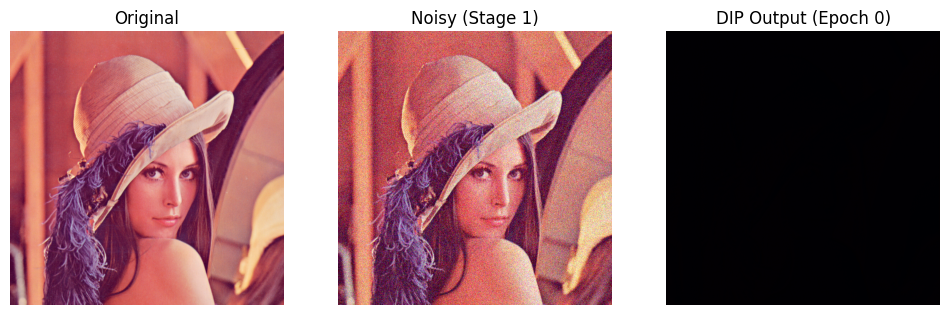

 99%|█████████▉| 991/1000 [02:57<00:01,  5.52it/s]

Epoch [999/1000], Loss: 0.0021, PSNR: 26.8662, SSIM: 0.7362


<Figure size 640x480 with 0 Axes>

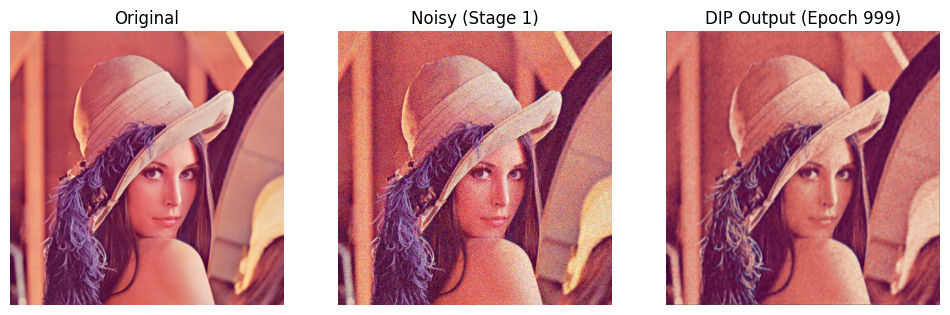

100%|██████████| 1000/1000 [02:59<00:00,  5.58it/s]


Training on stage 2 with noise level 0.05


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0/1000], Loss: 0.0023, PSNR: 26.3260, SSIM: 0.7997


<Figure size 640x480 with 0 Axes>

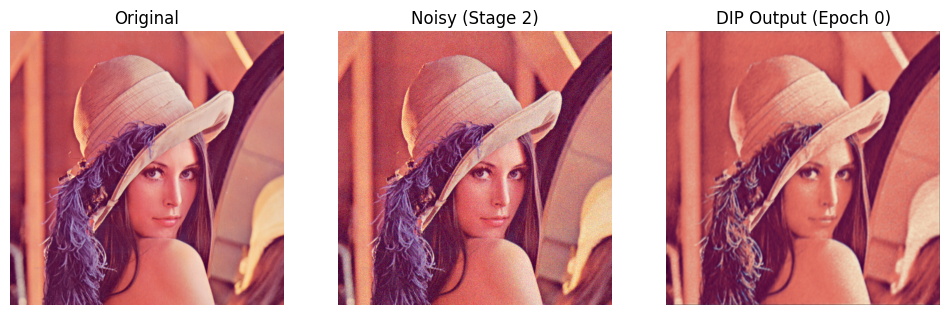

 98%|█████████▊| 980/1000 [02:59<00:03,  5.45it/s]


Early stopping at epoch 980 in stage 2
Training on stage 3 with noise level 0.025


  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch [0/1000], Loss: 0.0015, PSNR: 28.3490, SSIM: 0.8397


<Figure size 640x480 with 0 Axes>

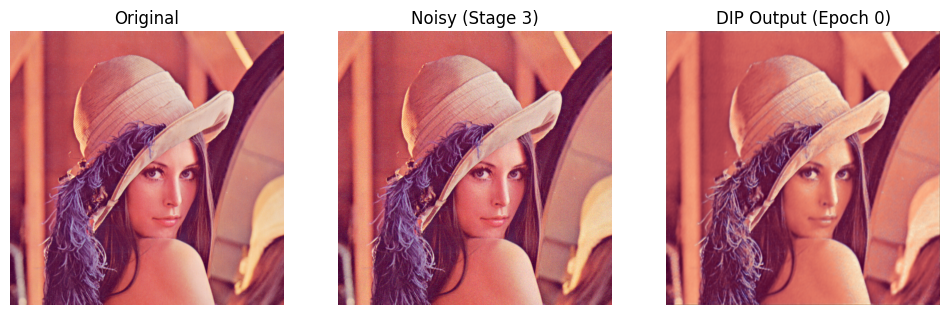

 58%|█████▊    | 580/1000 [01:46<01:17,  5.44it/s]

Early stopping at epoch 580 in stage 3


<Figure size 640x480 with 0 Axes>

In [15]:
for stage, noisy_img_torch in enumerate(noisy_images_torch):
    print(f"Training on stage {stage + 1} with noise level {noise_levels[stage]}")
    no_improvement_count = 0  # Counter for early stopping
    for epoch in tqdm(range(num_epochs_per_stage)):
        model.train()
        optimizer.zero_grad()
        output = model(noisy_img_torch)
        loss = criterion(output, target_img_torch)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs_per_stage - 1:
            model.eval()
            with torch.no_grad():
                output_img = output.squeeze().cpu().detach().numpy().transpose(1, 2, 0)
                output_img = np.clip(output_img, 0, 1)
                current_psnr = psnr(target_img, output_img, data_range=1.0)
                current_ssim = ssim(target_img, output_img, data_range=1.0, channel_axis=-1)
                psnr_history.append(current_psnr)
                # print(f"Stage: {stage}, Epoch: {epoch}, PSNR: {current_psnr:.4f}, SSIM: {current_ssim:.4f}")

                # Check for early stopping
                if current_psnr - best_psnr >= 0.001:
                    best_psnr = current_psnr
                    best_model = model.state_dict()
                    # no_improvement_count = 0  # Reset counter if improvement
                else:
                    no_improvement_count += 1

                if no_improvement_count >= patience:
                    print(f"Early stopping at epoch {epoch} in stage {stage + 1}")
                    break

            # Plot and save the current output image
            if epoch % 1000 == 0 or epoch == num_epochs_per_stage - 1:
                print(f'Epoch [{epoch}/{num_epochs_per_stage}], Loss: {loss.item():.4f}, PSNR: {current_psnr:.4f}, SSIM: {current_ssim:.4f}')
                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Original")
                plt.imshow(np.clip(target_img, 0, 1))
                plt.axis('off')
                plt.subplot(1, 3, 2)
                plt.title(f"Noisy (Stage {stage + 1})")
                plt.imshow(np.clip(noisy_images[stage], 0, 1))
                plt.axis('off')
                plt.subplot(1, 3, 3)
                plt.title(f"DIP Output (Epoch {epoch})")
                plt.imshow(output_img)
                plt.axis('off')
                plt.show()
                plt.savefig(f'stage_{stage + 1}_epoch_{epoch}.png')

In [16]:
model.load_state_dict(best_model)

<All keys matched successfully>

## Evaluation

In [17]:
model.eval()
with torch.no_grad():
    final_output = model(target_img_torch).squeeze().cpu().detach().numpy().transpose(1, 2, 0)
    final_output = np.clip(final_output, 0, 1)
    final_psnr = psnr(target_img, output_img, data_range=1.0)
    final_ssim = ssim(target_img, output_img, data_range=1.0, channel_axis=-1)
    print(f"Final PSNR: {final_psnr:.4f}, Final SSIM: {final_ssim:.4f}")

Final PSNR: 30.1730, Final SSIM: 0.8500


## Visulize the result

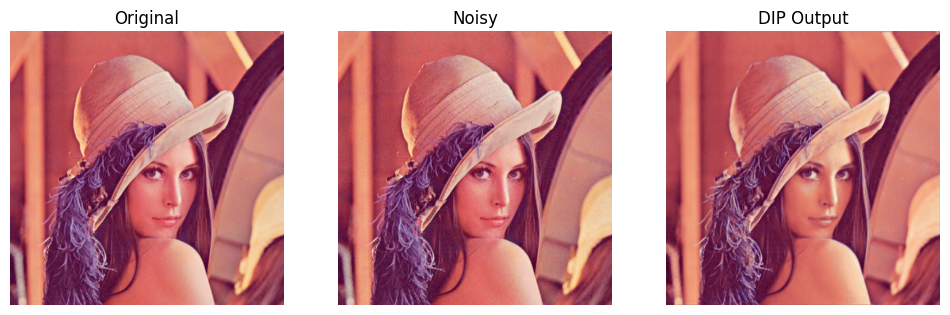

In [18]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(np.clip(target_img, 0, 1))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Noisy")
plt.imshow(np.clip(noisy_images[-1], 0, 1))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("DIP Output")
plt.imshow(final_output)
plt.axis('off')
plt.show()